### Project Milestone P2

The following notebook contains the first data manipulations and analysis. 
The used datasets comme from two websites: BeerAdvocate and RateBeer. We also have the data present in the two datasets. 
For each website, the used files are:   
- beers.csv 
- breweries.csv
- users.csv
- ratings.txt
- reviews.txt

In order to be able to use the ratings, the text file was converted into csv using the script txt-to-csv.py. 

We firstly combine the data from the two datasets, while taking into consideration the data present in both datasets. 

### PART 1: Merging (instead of matching) the data from the two websites into one.

In [1]:
import pandas as pd
import numpy as np
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from IPython.display import display
from geopy.distance import geodesic
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%load_ext autoreload
%autoreload 2

1. Loading the datasets

In [2]:
beers_rb = pd.read_csv("dataset/RateBeer/beers.csv")
beers_ba = pd.read_csv("dataset/BeerAdvocate/beers.csv")
beers_matched = pd.read_csv("dataset/MatchedData/beers.csv")

/var/folders/bk/1b5427d166x289f28sz15mqr0000gn/T/ipykernel_84677/309535741.py:3: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_matched = pd.read_csv("dataset/MatchedData/beers.csv")


In [3]:
users_rb = pd.read_csv("dataset/RateBeer/users.csv")
users_ba = pd.read_csv("dataset/BeerAdvocate/users.csv")
users_matched = pd.read_csv("dataset/MatchedData/users.csv")

In [4]:
ratings_rb = pd.read_csv("dataset/RateBeer/ratings-reviews.csv")
ratings_ba = pd.read_csv("dataset/BeerAdvocate/ratings.csv")
ratings_matched = pd.read_csv("dataset/MatchedData/ratings.csv")

/var/folders/bk/1b5427d166x289f28sz15mqr0000gn/T/ipykernel_84677/1269299031.py:3: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_matched = pd.read_csv("dataset/MatchedData/ratings.csv")


In [5]:
brewery_rb = pd.read_csv("dataset/RateBeer/breweries.csv")
brewery_ba = pd.read_csv("dataset/BeerAdvocate/breweries.csv")
brewery_matched = pd.read_csv("dataset/MatchedData/breweries.csv")

2. Changing the beer_id in the BeerAdvocate dataset, so that each beer id is unique

In [6]:
# ID's of the beers coming from the two websites should be unique. However, there are intersections for now, which would cause problems after merging. That's why we add 1000000 to id's of the BeerAdvocate beers.

ba_id = beers_ba['beer_id'].values
rb_id = beers_rb['beer_id'].values
ba_id = ba_id + 1000000

#Checking whether the overlapping problem is solved:
if np.intersect1d(ba_id, rb_id).size > 0:
    print(np.intersect1d(ba_id, rb_id).size)
    
beers_ba['beer_id'] = beers_ba['beer_id'] + 1000000
ratings_ba['beer_id'] = ratings_ba['beer_id'] + 1000000
beers_matched['ba.5'][1:] = beers_matched['ba.5'][1:].astype(int) + 1000000
beers_matched['rb.4'][1:] = beers_matched['rb.4'][1:].astype(int)

#Finding the dictionary that maps the beers from BeerAdvocate to RateBeer (for the beers that are the same) by the help of matched data provided:
ba_to_rb_beer_id_dict = dict(zip(beers_matched['ba.5'], beers_matched['rb.4']))

3. Changing the brewery_id in the BeerAdvocate dataset, so that each brewery id is unique

In [7]:
# ID's of the breweries coming from the two websites should be unique. However, there are intersections for now, which would cause problems after merging. That's why we add 1000000 to id's of the BeerAdvocate breweries, again.

ba_id = brewery_ba['id'].values
rb_id = brewery_rb['id'].values
ba_id = ba_id + 1000000

#Checking whether the overlapping problem is solved:
if np.intersect1d(ba_id, rb_id).size > 0:
    print(np.intersect1d(ba_id, rb_id).size)

brewery_ba['id'] = brewery_ba['id'] + 1000000
beers_ba['brewery_id'] = beers_ba['brewery_id'] + 1000000
ratings_ba['brewery_id'] = ratings_ba['brewery_id'] + 1000000
brewery_matched['ba'][1:] = brewery_matched['ba'][1:].astype(int) + 1000000
brewery_matched['rb'][1:] = brewery_matched['rb'][1:].astype(int)

#Finding the dictionary that maps the breweries from BeerAdvocate to RateBeer (for the breweries that are the same) by the help of matched data provided:
ba_to_rb_brewery_id_dict = dict(zip(brewery_matched['ba'], brewery_matched['rb']))

4. Checking for the users id

In [8]:
ba_id = users_ba['user_id'].values
rb_id = users_rb['user_id'].astype(str).values

#Checking if there is the same ID overlap problem for the users as well:
if np.intersect1d(ba_id, rb_id).size > 0:
    print(np.intersect1d(ba_id, rb_id).size)

#Finding the dictionary that maps the users from BeerAdvocate to RateBeer (for the users that are the same) by the help of matched data provided:  
ba_to_rb_user_id_dict = dict(zip(users_matched['ba.4'], users_matched['rb.3']))

5. Finding the style names present in each dataset, and harmonize the styles between the websites

In [9]:
#Finding the style of beers present in the matched data and RateBeer data separately:
matched_rb_beers = beers_matched['rb.12'].unique()
all_rb_beers = beers_rb['style'].unique()

#Finding the styles that are in RateBeer but not in the matched data:
elements_not_in_matched = [element for element in all_rb_beers if element not in matched_rb_beers]

#The styles that are in RateBeer but not in the matched data have received very few ratings. Furthermore, we will map the styles of BeerAdvocate to the styles of RateBeer using the matched data. Since no BeerAdvocate beers will be mapped to this set of beers, they will appear even less popular in the results. Therefore, we eliminate these styles here.
beers_rb = beers_rb[~beers_rb['style'].isin(elements_not_in_matched)]
ratings_rb = ratings_rb[~ratings_rb['style'].isin(elements_not_in_matched)]

In [10]:
#Inspecting the matched data we realize that there is no one to one matched between the "style" labels of the two websites. For example: a beer with style label of "English Pale Ale" on BeerAdvocate is labeled as having the style "Golden Ale/Blond Ale" in RateBeer. But another beer, whose style is also "English Pale Ale" on BeerAdvocate has this time style label of "Amber Ale" in RateBeer. 

# In order to match the BeerAdvocate styles to the RateBeer styles, we look at all the instances of each unique beer in BeerAdvocate and find its most frequent corresponding style in RateBeer. We then collect each unique style in BeerAdvocate, its most frequent match and the most frequent match count in a dataframe.

ba_to_rb = []
for style_value in beers_matched['ba.14'].unique():
    # Filter the DataFrame for rows where 'style_column1' matches the current value
    filtered_rows = beers_matched[beers_matched['ba.14'] == style_value]
    
    # Find the most frequent match in 'style_column2'
    most_frequent_match = filtered_rows['rb.12'].mode().iloc[0]
    
    # Count the occurrences of the most frequent match
    match_count = filtered_rows[filtered_rows['rb.12'] == most_frequent_match].shape[0]
    
    # Append the results to the result DataFrame
    # 
    ba_to_rb.append({'style_column1': style_value,
                                  'most_frequent_match': most_frequent_match,
                                  'match_count': match_count})
ba_to_rb.pop(0)
ba_to_rb_df = pd.DataFrame(ba_to_rb)

In [11]:
#Printing the resulting dataFrame: 
ba_to_rb_df.head()

,style_column1,most_frequent_match,match_count
0,English Pale Ale,Golden Ale/Blond Ale,254
1,English Bitter,Bitter,484
2,American Pale Wheat Ale,Wheat Ale,549
3,Irish Dry Stout,Dry Stout,187
4,American Pale Ale (APA),American Pale Ale,2500


In [12]:
#We see that all the styles of the BeerAdvocate are mapped to 71 different beer styles in RateBeer using the above-explained procedure. We would like to have one-to-one mapping between the styles of two websites such that not only all the styles of BeerAdvocate are mapped to a style of RateBeer, all styles of RateBeer are also mapped to a BeerAdvocate style.

#For this, we first find which styles of RateBeer are not mapped to a BeerAdvocate beer in the previous cell.
rb_to_ba_styles = ba_to_rb_df.most_frequent_match.unique()
matched_rb_styles = beers_matched['rb.12'].unique()
elements_not_in_ba = [element for element in matched_rb_styles if element not in rb_to_ba_styles]

In [13]:
#For the RateBeer styles that are not mapped, we first find their most frequent match in BeerAdvocate, and then map it back to one of the RateBeer styles as done before. By doing this, we make sure that all the BeerAdvocate styles are mapped to a RateBeer style and vice versa.

rb_to_ba_df = []
for style_value in elements_not_in_ba:
    # Filter the DataFrame for rows where 'style_column1' matches the current value
    filtered_rows = beers_matched[beers_matched['rb.12'] == style_value]
    
    # Find the most frequent match in 'style_column2'
    most_frequent_match = filtered_rows['ba.14'].mode().iloc[0]
    
    # Count the occurrences of the most frequent match
    match_count = filtered_rows[filtered_rows['ba.14'] == most_frequent_match].shape[0]
    
    # Append the results to the result DataFrame
    rb_to_ba_df.append({'style_column1': style_value,
                                  'most_frequent_match': most_frequent_match,
                                  'match_count': match_count})
rb_to_ba_df = pd.DataFrame(rb_to_ba_df)

In [14]:
#Finding the dictionary that maps the "unmapped" RateBeer styles to one of the BeerAdvocate styles:

rb_to_ba_dict = dict(zip(rb_to_ba_df['style_column1'], rb_to_ba_df['most_frequent_match']))
beers_matched['rb.12'] = beers_matched['rb.12'].replace(rb_to_ba_dict)
beers_rb['style'] = beers_rb['style'].replace(rb_to_ba_dict)
ratings_rb['style'] = ratings_rb['style'].replace(rb_to_ba_dict)

In [15]:
display(rb_to_ba_dict)

{'style': 'style',
 'Imperial Porter': 'American Porter',
 'Session IPA': 'American IPA',
 'Czech Pilsner (Světlý)': 'Czech Pilsener',
 'English Pale Ale': 'English Pale Ale',
 'Premium Lager': 'American Pale Lager',
 'India Style Lager': 'American Pale Lager',
 'Radler/Shandy': 'Fruit / Vegetable Beer',
 'Polotmavý': 'Czech Pilsener',
 'Cider': 'Fruit / Vegetable Beer'}

In [16]:
#Mapping these styles back to one of the 71 RateBeer styles:

ba_to_rb_dict = dict(zip(ba_to_rb_df['style_column1'], ba_to_rb_df['most_frequent_match']))
beers_ba['style'] = beers_ba['style'].replace(ba_to_rb_dict)
beers_matched['rb.12'] = beers_matched['rb.12'].replace(ba_to_rb_dict)
beers_rb['style'] = beers_rb['style'].replace(ba_to_rb_dict)
ratings_rb['style'] = ratings_rb['style'].replace(ba_to_rb_dict)

In [17]:
matched_rb_ids = beers_matched['rb.4'][1:]
matched_ba_ids = beers_matched['ba.5'][1:]

6. After those modifications, merging of the datasets

In [18]:
#Removing the matched beers from the two websites before merging:

rb_without_matched = beers_rb[~beers_rb['beer_id'].isin(matched_rb_ids)]
ba_without_matched = beers_ba[~beers_ba['beer_id'].isin(matched_ba_ids)]

In [19]:
#First, we take only the necessary columns of beer datasets and rename them conveniently. 

columns_to_take = ['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style', 'abv']
column_name_mapping = {'rb.4': 'beer_id', 'rb.5': 'beer_name', 'rb.7': 'brewery_id', 'rb.8': 'brewery_name', 'rb.12': 'style', 'rb': 'abv'}
beers_matched.rename(columns = column_name_mapping, inplace = True)

#We first merge the beer datasets from the two websites. Note that the matched beers were eliminated from these datasets beforehand.
merged_beers = pd.concat([rb_without_matched[columns_to_take], ba_without_matched[columns_to_take]], axis=0, ignore_index = True)

#Now we include the matched beers in the merged datasets, making sure that the matched beers are not repeated but included only once.
merged_beers = pd.concat([merged_beers, beers_matched.iloc[1:][columns_to_take]], axis=0, ignore_index = True)

In [20]:
#Before merging the breweries, removing the matched breweries from BeerAdvocate and then merging this directly with the original brewery data of RateBeer:

matched_ba_ids = brewery_matched['ba'][1:]
ba_without_matched = brewery_ba[~brewery_ba['id'].isin(matched_ba_ids)]
merged_breweries = pd.concat([brewery_rb, ba_without_matched], axis = 0, ignore_index = True)

In [21]:
#Before merging the users, removing the matched users from BeerAdvocate and then merging this directly with the original user data of RateBeer:

matched_ba_ids = users_matched['ba.4'][1:]
ba_without_matched = users_ba[~users_ba['user_id'].isin(matched_ba_ids)]
merged_users = pd.concat([users_rb, ba_without_matched], axis = 0, ignore_index = True)
merged_users['user_id'] = merged_users['user_id'].astype(str)

In [22]:
#The BeerAdvocate dataset user_id's, beer_id's and brewery_id's are changed to be aligned to the Ratebeer dataset, according to the association described earlier.  Before merging the ratings data of the two websites, we update the corresponding columns of the BeerAdvocate datasets using the dictionaries calculated beforehand. 

ratings_ba['style'] = ratings_ba['style'].replace(ba_to_rb_dict)
ratings_ba['user_id'] = ratings_ba['user_id'].replace(ba_to_rb_user_id_dict)
ratings_ba['beer_id'] = ratings_ba['beer_id'].replace(ba_to_rb_beer_id_dict)
ratings_ba['brewery_id'] = ratings_ba['brewery_id'].replace(ba_to_rb_brewery_id_dict)

In [23]:
#Adjusting the data types:

ratings_matched = ratings_matched.iloc[1:]

ratings_matched['ba.15'] = ratings_matched['ba.15'].astype(str)
ratings_matched['ba.7'] = ratings_matched['ba.7'].astype(np.int64)
ratings_matched['ba.3'] = ratings_matched['ba.3'].astype(np.int64)

ratings_matched['rb.14'] = ratings_matched['rb.14'].astype(str)
ratings_matched['rb.7'] = ratings_matched['rb.7'].astype(np.int64)
ratings_matched['rb.3'] = ratings_matched['rb.3'].astype(np.int64)

# List of usernames present in both websites, using BA information:
listed_ba_user = list(ratings_matched['ba.15'])
listed_ba_date = list(ratings_matched['ba.7'])
listed_ba_beer = list(ratings_matched['ba.3'])

# List of usernames present in both websites, using RB information:
listed_rb_user=list(ratings_matched['rb.14'])
listed_rb_date = list(ratings_matched['rb.7'])
listed_rb_beer = list(ratings_matched['rb.3'])

# Creating triples to be able to uniquely identify the matched ratings (ratings that are given for the same beer in the two websites by the same user) in each of the websites:
couple_ba = list(zip(listed_rb_user, listed_ba_date, listed_rb_beer))
couple_rb = list(zip(listed_rb_user, listed_rb_date, listed_rb_beer))

# Selecting only the rows that do not match the triples for BeerAdvocate, dropping review column and adding a new column to indicate the website for the future z-score calculations:
ratings_ba['user_id'] = ratings_ba['user_id'].astype(str)
ratings_ba['date'] = ratings_ba['date'].astype(np.int64)
ratings_ba['beer_id'] = ratings_ba['beer_id'].astype(np.int64)
df_ba_removed = ratings_ba[~ratings_ba.set_index(['user_id', 'date', 'beer_id']).index.isin(couple_ba)]
df_ba_removed = df_ba_removed.drop('review', axis = 1)
df_ba_removed['website'] = 1

# Selecting only the rows that do not match the triples for RateBeer and adding a new column to 
# indicate the website for the future z-score calculations:
ratings_rb['user_id'] = ratings_rb['user_id'].astype(str)
ratings_rb['date'] = ratings_rb['date'].astype(np.int64)
ratings_rb['beer_id'] = ratings_rb['beer_id'].astype(np.int64)
df_rb_removed = ratings_rb[~ratings_rb.set_index(['user_id', 'date', 'beer_id']).index.isin(couple_rb)]
df_rb_removed['website'] = 0

merged_ratings = pd.concat([df_ba_removed, df_rb_removed], axis = 0, ignore_index=True)

merged_ratings['date'] = merged_ratings['date'].apply(convert_unix_timestamp)
merged_ratings['year'] = merged_ratings['date'].dt.year

/var/folders/bk/1b5427d166x289f28sz15mqr0000gn/T/ipykernel_84677/4025831808.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rb_removed['website'] = 0


In [24]:
#Recalculating the number of ratings:

rating_counts_by_user = merged_ratings.groupby('user_id')['beer_id'].count()
rating_counts_by_user_dict = rating_counts_by_user.to_dict()
merged_users['nbr_ratings'] = merged_users['nbr_ratings'].replace(rating_counts_by_user_dict)

In [25]:
merged_beers.to_csv("dataset/MergedData/beers.csv", index = False)
merged_breweries.to_csv("dataset/MergedData/breweries.csv", index = False)
merged_users.to_csv("dataset/MergedData/users.csv", index = False)
merged_ratings.to_csv("dataset/MergedData/ratings.csv", index = False)

In [26]:
beers = pd.read_csv('dataset/MergedData/beers.csv')
breweries = pd.read_csv('dataset/MergedData/breweries.csv')
ratings = pd.read_csv('dataset/MergedData/ratings.csv', dtype = {'user_id': str})
users = pd.read_csv('dataset/MergedData/users.csv', dtype = {'user_id': str})

### PART 2: Preprocessing of the merged data before initial analysis

1. Preprocessing of the ratings

We compute the z-score for each rating and sub-rating feature

Two main observations were made here: 
 - The mean rating is not the same for the two websites
 - The mean rating augments with the years

As we do not want those effects to be reflected on our results, the z-score was calculated. 
For each feature, we substracted the mean for this year and the corresponding website, and divided by the standard deviation.

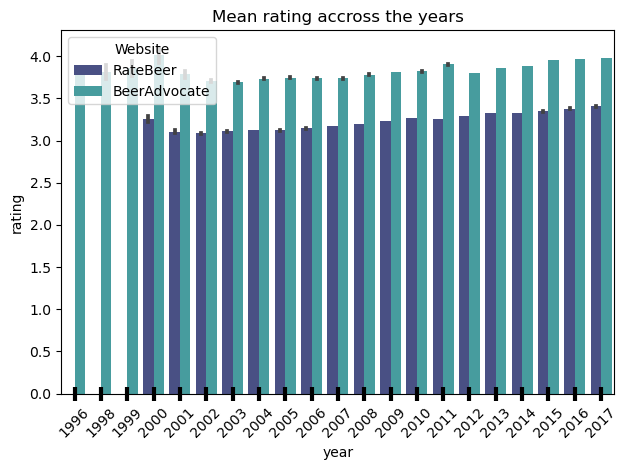

In [27]:
f = sns.barplot(data=ratings, x='year', y='rating', hue='website', order=sorted(ratings['year'].unique()), palette='mako')
f.tick_params(axis='x', which='major', length = 10, width=3, direction='inout')
plt.xticks(rotation=45)
f.set_title("Mean rating accross the years")

handles, labels = f.get_legend_handles_labels()
f.legend(handles, ['RateBeer', 'BeerAdvocate'], title='Website', loc='upper left')

plt.tight_layout()

In [28]:
#Calculating z-scores for all types of ratings by normalizing with respect to the mean and standard deviation of the corresponding website's ratings of that year:

ratings['rating'] = (ratings['rating'] - ratings.groupby(['year', 'website'])['rating'].transform('mean')) / ratings.groupby(['year', 'website'])['rating'].transform('std')

ratings['appearance'] = (ratings['appearance'] - ratings.groupby(['year', 'website'])['appearance'].transform('mean')) / ratings.groupby(['year', 'website'])['appearance'].transform('std')

ratings['aroma'] = (ratings['aroma'] - ratings.groupby(['year', 'website'])['aroma'].transform('mean')) / ratings.groupby(['year', 'website'])['aroma'].transform('std')

ratings['palate'] = (ratings['palate'] - ratings.groupby(['year', 'website'])['palate'].transform('mean')) / ratings.groupby(['year', 'website'])['palate'].transform('std')

ratings['taste'] = (ratings['taste'] - ratings.groupby(['year', 'website'])['taste'].transform('mean')) / ratings.groupby(['year', 'website'])['taste'].transform('std')

ratings['overall'] = (ratings['overall'] - ratings.groupby(['year', 'website'])['overall'].transform('mean')) / ratings.groupby(['year', 'website'])['overall'].transform('std')

In [29]:
#Visualizing the ratings dataframe as a sanity check:

ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,website,year
0,Régab,1142544,Societe des Brasseries du Gabon (SOBRAGA),1037262,Pale Lager,4.5,2015-08-20 10:00:00,nmann08,101495,-1.393976,-2.057290,-1.199632,-2.042947,-1.698431,-1.970329,"From a bottle, pours a piss yellow color with ...",1,2015
1,Barelegs Brew,1019590,Strangford Lough Brewing Company Ltd,4959,Golden Ale/Blond Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,-1.462793,-0.396151,-0.421158,0.249223,-0.499760,-0.240900,Pours pale copper with a thin head that quickl...,1,2009
2,Barelegs Brew,1019590,Strangford Lough Brewing Company Ltd,4959,Golden Ale/Blond Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,0.310025,-0.265126,-0.279445,0.339157,-0.381048,-0.013315,"500ml Bottle bought from The Vintage, Antrim.....",1,2006
3,Barelegs Brew,1019590,Strangford Lough Brewing Company Ltd,4959,Golden Ale/Blond Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,0.318086,-0.246417,0.436833,0.332241,0.951909,0.369234,Serving: 500ml brown bottlePour: Good head wit...,1,2004
4,Barelegs Brew,1019590,Strangford Lough Brewing Company Ltd,4959,Golden Ale/Blond Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,0.318086,0.437153,0.436833,0.332241,0.290417,0.399252,"500ml bottlePours with a light, slightly hazy ...",1,2004


In [30]:
#Inspecting some statistics of our dataset:

print(f"Number of unique beers: {len(beers['beer_id'].unique())}")
print(f"Number of beers with ratings: {len(ratings['beer_id'].unique())}\n")

print(f"Number of unique beer styles: {len(beers['style'].unique())}\n")

print(f"Number of unique breweries: {len(breweries['id'].unique())}")
print(f"Number of breweries with ratings: {len(ratings['brewery_id'].unique())}\n")

print(f"Number of unique users: {len(users['user_id'].unique())}")
print(f"Number of users with ratings: {len(ratings['user_id'].unique())}\n")

print(f"Total number of ratings: {len(ratings)}")

print("Nan: ")
ratings.isna().sum()

Number of unique beers: 676988
Number of beers with ratings: 606006

Number of unique beer styles: 71

Number of unique breweries: 32666
Number of breweries with ratings: 28464

Number of unique users: 220804
Number of users with ratings: 220782

Total number of ratings: 15468484
Nan: 


beer_name             0
beer_id               0
brewery_name          0
brewery_id            0
style                 0
abv              346266
date                  0
user_name            31
user_id               0
appearance      3620689
aroma           3620689
palate          3620689
taste           3620689
overall         3620689
rating                1
text            5673637
website               0
year                  0
dtype: int64

This is interesting to note that there is exactly the same number of missing values for the ratings of the different aspects of the beer. It is probably due to the fact that there are two "levels" of rating: an overall grade, that would be quicker to make, or a rating for each aspect (in which case the user has to respond to all the fields). 

When we will study the effect of each aspect, those NaN for those and for abv will be ignored. However, those values are not relevant for all our research, so we will keep all the values in a first time. 

The text review and usernames won't be analyzed eather, so the NaN are not problematic.

2. Preprocessing of the alcohol content

We check the values of abv, and filter the dataset.

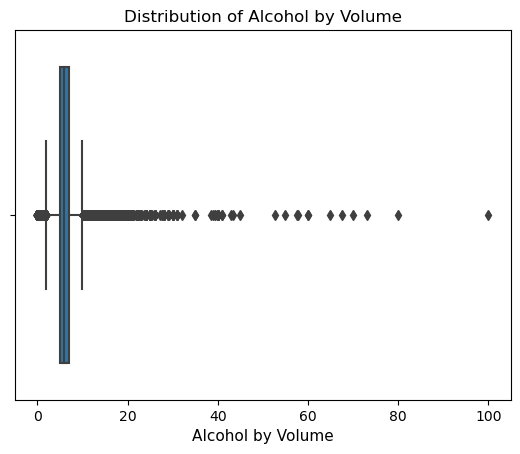

In [31]:
#Looking at the distribution of the alcohol by volume of beers:
sns.boxplot(beers, x = "abv")

plt.title('Distribution of Alcohol by Volume', fontsize = 12)
plt.xlabel('Alcohol by Volume', fontsize = 11)
plt.show()

We see that there are some beers with unrealisticly high alcohol percentages. After a research, we concluded that data coming from these beers are unreliable and we decided to eliminate the beers with more that 50 percent of alcohol by volume.

In [32]:
beers = beers[beers['abv'] < 50]
ratings = ratings[ratings['abv'] < 50]

3. Check the users and their number of ratings

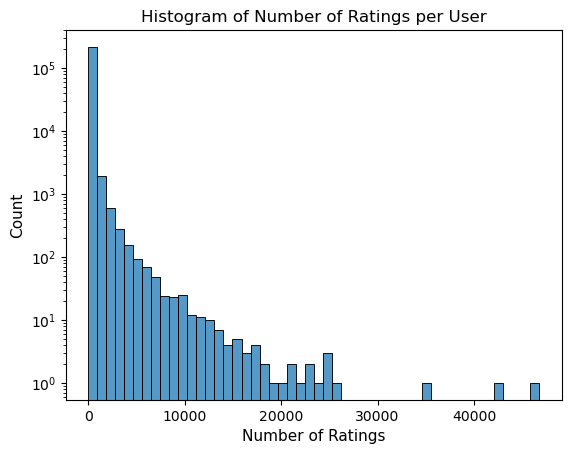

In [33]:
ax = sns.histplot(users['nbr_ratings'], bins = 50, log_scale=(False, True))

ax.set_title('Histogram of Number of Ratings per User', fontsize = 12)
ax.set_xlabel('Number of Ratings', fontsize = 11)
ax.set_ylabel('Count', fontsize = 11)
plt.show()

We see that there are some users with unrealistic number of rated beers. Looking at the plot, we identify users with more than 20,000 ratings as outliers and both eliminate them as users and also eliminate their ratings.

In [34]:
outlier_user_ids = users[users['nbr_ratings'] >= 20000]['user_id'].values
users = users[~users['user_id'].isin(outlier_user_ids)]
ratings = ratings[~ratings['user_id'].isin(outlier_user_ids)]

4. Additional datasets

In [35]:
#Reading additional population datasets that will be useful for location filtering. The datasets are showing populations of all the relevant locations for 2010, which is a suitable year for our year range.

us_state_populations = pd.read_csv('dataset/AdditionalData/US_state_populations.csv')
world_population = pd.read_csv("dataset/AdditionalData/world_population.csv")


display(us_state_populations.head(5))
display(world_population.head(5))

,states,2010
0,"United States, Alabama",4785514
1,"United States, Alaska",713982
2,"United States, Arizona",6407342
3,"United States, Arkansas",2915918
4,"United States, California",37319550


,location,2010
0,Afghanistan,28189672
1,Albania,2913399
2,Algeria,35856344
3,American Samoa,54849
4,Andorra,71519


In [36]:
#Contacenating the two datasets into one and creating a location-population dictionary:

us_state_populations.rename(columns = {'states': 'location'}, inplace = True)
populations_by_location = pd.concat([us_state_populations, world_population], ignore_index = True)
populations_by_location_dict = dict(zip(populations_by_location['location'], populations_by_location['2010']))

5. Filtering locations to include in the study

To have meaningful results, we decided to remove the countries with a low number of users. In order to do that, we compute the proportion of users among the population. 

In [37]:
#Finding the portion (as percentage) of population for each location that are users in either of the websites. Then, we print the list of locations that are not present in the additional datasets. We see that all the locations are very small countries, so that exclusion of them will not be significant for our future analysis.

num_users_by_location = users['location'].value_counts().reset_index()
percentage_users_by_location = []
missing_locations = []
for index, row in num_users_by_location.iterrows():
    location = row['location']
    if location in populations_by_location_dict:
        percentage_users_by_location.append({'location': location, 'percentage': 100 * row['count'] / populations_by_location_dict[location], 'population': populations_by_location_dict[location], 'users': row['count']})
    else:
        missing_locations.append(location)

percentage_users_by_location = pd.DataFrame(percentage_users_by_location)

print(percentage_users_by_location)  
print(missing_locations)

                         location  percentage  population  users
0       United States, California    0.038018    37319550  14188
1     United States, Pennsylvania    0.079865    12711406  10152
2         United States, New York    0.044577    19399956   8648
3         United States, Illinois    0.063190    12840545   8114
4    United States, Massachusetts    0.110364     6566440   7247
..                            ...         ...         ...    ...
222                          Iran    0.000001    75373855      1
223                       Jamaica    0.000037     2733896      1
224                          Cuba    0.000009    11290417      1
225                   Saint Lucia    0.000585      170935      1
226                    Micronesia    0.000929      107588      1

[227 rows x 4 columns]
['Aotearoa', 'Virgin Islands (U.S.)', 'Antarctica', 'Ascension Island', 'Abkhazia', 'Svalbard and Jan Mayen Islands', 'Bouvet Island', 'Fiji Islands', 'Hawaii', 'Dem Rep of Congo', 'Kosovo', 'Sain

In [38]:
percentage_users_by_location.sort_values(by = 'percentage', ascending = False, inplace = True)
percentage_users_by_location

,location,percentage,population,users
162,Vatican City,0.503356,596,3
44,"United States, Vermont",0.141240,625886,884
4,"United States, Massachusetts",0.110364,6566440,7247
32,"United States, New Hampshire",0.100850,1316807,1328
19,"United States, Connecticut",0.085243,3579173,3051
...,...,...,...,...
160,Nigeria,0.000002,160952853,4
181,Ethiopia,0.000002,89237791,2
151,Pakistan,0.000002,194454498,4
192,Bangladesh,0.000001,148391139,2


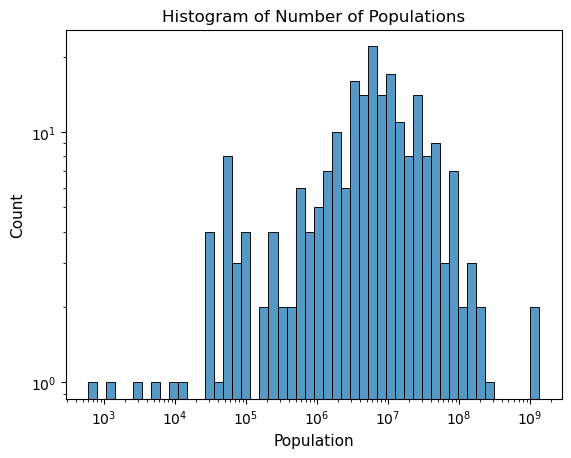

In [39]:
#Histogram of the populations

ax = sns.histplot(percentage_users_by_location['population'], bins = 50, log_scale=(True, True))
ax.set_title('Histogram of Number of Populations', fontsize = 12)
ax.set_xlabel('Population', fontsize = 11)
ax.set_ylabel('Count', fontsize = 11)
plt.show()

Looking at the histogram, we identify locations (countries) that have a population smaller than 100,000 as outliers and eliminate them.

In [40]:
percentage_users_by_location = percentage_users_by_location[percentage_users_by_location['population'] > 1e5]

In [41]:
print(percentage_users_by_location.to_string())

                          location  percentage  population  users
44          United States, Vermont    0.141240      625886    884
4     United States, Massachusetts    0.110364     6566440   7247
32    United States, New Hampshire    0.100850     1316807   1328
19      United States, Connecticut    0.085243     3579173   3051
46     United States, Rhode Island    0.082164     1053994    866
1      United States, Pennsylvania    0.079865    12711406  10152
40            United States, Maine    0.076074     1327651   1010
14        United States, Minnesota    0.066768     5310934   3546
3          United States, Illinois    0.063190    12840545   8114
20         United States, Colorado    0.060346     5047539   3046
52         United States, Delaware    0.058356      899647    525
13       United States, Washington    0.056281     6743009   3795
23           United States, Oregon    0.056103     3837614   2153
18        United States, Wisconsin    0.055267     5690538   3145
9         

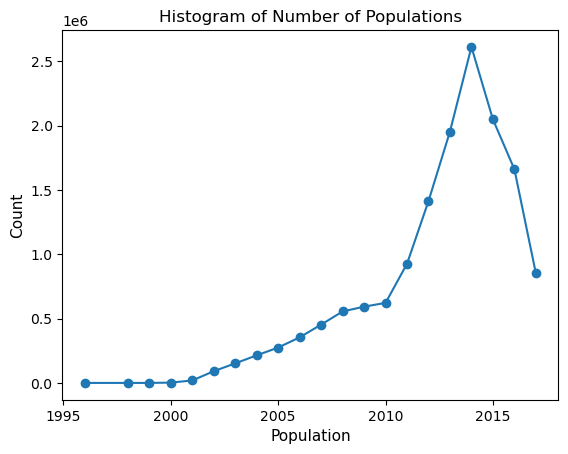

In [42]:
#Line plot of number of ratings by year:

rating_counts_by_year = ratings['year'].value_counts().reset_index().sort_values(by = 'year')
plt.plot(rating_counts_by_year['year'], rating_counts_by_year['count'], marker = 'o')

plt.title('Histogram of Number of Populations', fontsize = 12)
plt.xlabel('Population', fontsize = 11)
plt.ylabel('Count', fontsize = 11)
plt.show()

We need to decide on a set of years for our future analysis based on the presence of sufficient amount of data. However, looking at this line plot alone is not enough to make a decision. We want to know the number of locations with more than 50 ratings for each year. 

In [43]:
ratings_users = pd.merge(ratings, users[['user_id', 'nbr_ratings', 'location']], on='user_id',how='inner')

In [44]:
#Creating a dataframe that gives the rating counts of each year and location pair:
year_location_counts = ratings_users.groupby(['year', 'location'])['user_id'].count().reset_index()

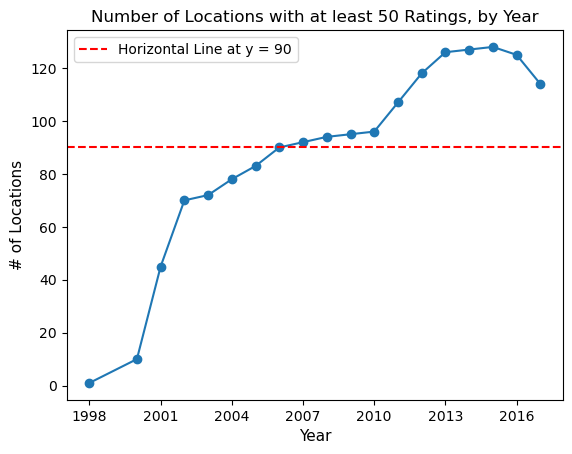

In [45]:
year_location_counts_filtered = year_location_counts[year_location_counts['user_id'] >= 50]['year'].value_counts().reset_index().sort_values(by = 'year')
plt.plot(year_location_counts_filtered['year'], year_location_counts_filtered['count'], marker = 'o')


ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.axhline(y = 90, color='red', linestyle='--', label = 'Horizontal Line at y = 90')
plt.title('Number of Locations with at least 50 Ratings, by Year', fontsize = 12)
plt.xlabel('Year', fontsize = 11)
plt.ylabel('# of Locations', fontsize = 11)
plt.legend()
plt.show()

We see that beginning from the year 2006, the number of locations satisfying the threshold of at least 50 ratings more or less stabilizes after crossing the number of 90 locations. Due to lack of data to conclude reliable results for the earlier years, we decide to consider only the years after and including 2006.

In [46]:
ratings = ratings[ratings['year'] >= 2006]

In [47]:
year_location_counts = year_location_counts[year_location_counts['user_id'] >= 50]
year_location_counts = year_location_counts[year_location_counts['year'] >= 2006]

In [48]:
#Finding the set of locations that satisfy the at least 50 ratings limit for each year after and including 2006. These locations are identified as "valid".

valid_year_num_by_location = year_location_counts['location'].value_counts().reset_index()
valid_locations = valid_year_num_by_location[valid_year_num_by_location['count'] == 12]['location'].values
valid_locations

array(['United States, North Carolina', 'United States, Nebraska',
       'United States, Missouri', 'United States, Mississippi',
       'United States, Minnesota', 'United States, Michigan',
       'United States, Massachusetts', 'United States, Maryland',
       'United States, Maine', 'United States, Louisiana',
       'United States, Kentucky', 'United States, Kansas',
       'United States, Iowa', 'United States, Indiana',
       'United States, Illinois', 'United States, Idaho',
       'United States, Hawaii', 'United States, Georgia',
       'United States, Florida', 'United States, Delaware',
       'United States, Connecticut', 'United States, Montana',
       'United States, New Hampshire', 'United States, California',
       'United States, New Jersey', 'United States, Wyoming',
       'United States, Wisconsin', 'United States, West Virginia',
       'United States, Washington', 'United States, Virginia',
       'United States, Vermont', 'United States, Utah',
       'Unit

In [49]:
#We decided that a sensible condition to decide the final set of locations of interest is the following: The location should be in the "valid locations" (at least 50 ratings for every year) AND [the percentage of users should be greater than or equal to 0.004 OR the number of users from that location should be at least 500]. This ensures that there are enough data in each year and it is representative of the whole population of the location.

final_locations = percentage_users_by_location[percentage_users_by_location['location'].isin(valid_locations) & ((percentage_users_by_location['percentage'] >= 0.004) | (percentage_users_by_location['users'] >= 500))]['location']

all_locations = final_locations.tolist()

final_locations

44          United States, Vermont
4     United States, Massachusetts
32    United States, New Hampshire
19      United States, Connecticut
46     United States, Rhode Island
                  ...             
41                           Spain
38                           Italy
35                         Germany
48                          France
39                          Brazil
Name: location, Length: 71, dtype: object

In [50]:
#Saving the filtered data:

users = users[users['location'].isin(all_locations)]
ratings = ratings[ratings['user_id'].isin(users['user_id'].unique())]

beers.to_csv("dataset/FilteredData/beers.csv", index = False)
breweries.to_csv("dataset/FilteredData/breweries.csv", index = False)
users.to_csv("dataset/FilteredData/users.csv", index = False)
ratings.to_csv("dataset/FilteredData/ratings.csv", index = False)

### PART 3: Initial Analysis

1.  Visualizations on the World Map

In [51]:
#Using a function that returns the corresponding latitude and longitude of the input location name, we put all our final location set on the world map to visualize their geographical distribution.

def geocode_location(location_name):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.geocode(location_name)
    if location:
        return location.latitude, location.longitude
    else:
        return None

location_latitudes_longitudes = []
location_latitudes_longitudes_tuples = []
for location in all_locations:
    res = geocode_location(location)
    if res:
        lat,long = res
        location_latitudes_longitudes.append([lat, long])
        location_latitudes_longitudes_tuples.append(res)

In [52]:
map_center = [20,0]
my_map = folium.Map(location = map_center, zoom_start = 1)

for i, location in enumerate(all_locations):
    folium.CircleMarker(location = location_latitudes_longitudes[i], radius = 5, color='blue', fill=True, fill_color='blue', fill_opacity = 0.7, popup = location).add_to(my_map)
    
display(my_map)

One can see that our set of locations are distributed such that they are mainly populated around North America and North Europe. However, we have also some outliers that are far away from these groups, such as New Zealand or Australia. Such a contrast could allow us to investigate and compare/contrast the trend behaviour among the neighbor locations as well as more separated ones.

In [53]:
#Using a function that returns the corresponding latitude and longitude of the input location name, we put all our brewery locations on the world map to visualize their geographical distribution.

all_brewery_locations = breweries['location'].tolist()
all_distinct_brewery_locations = list(set(all_brewery_locations))
brewery_latitudes_longitudes = []
my_map = folium.Map(location = [20, 0], zoom_start = 3)
for location in all_distinct_brewery_locations:
    try:
        res = geocode_location(location)
    except:
        continue
    if res:
        lat,long = res
        brewery_latitudes_longitudes.append([lat, long])
 
#Using a heatmap to better indicate the density of breweries per location:        
HeatMap(brewery_latitudes_longitudes).add_to(my_map)
display(my_map)

2. Popularity and Rating Trend Analysis

3.2.1: Initial Analysis of Style Trends by Location

In [54]:
#Extracting the most popular (in quantity) beer style for each location by looking at the total number of ratings by year. We also put a threshold of 5 that needs to be satisfied for a location-style pair to be considered in this analysis.

years = np.arange(2006, 2018)
style_popularities_by_year = pd.DataFrame()
for year in years:
    location_style = location_style_stats(ratings.copy(), users.copy(), year, 5)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_most_popular = location_style_groupedby_loc['number'].idxmax()
    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style']]
    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    style_popularities_by_year = pd.concat([style_popularities_by_year, most_popular_styles_by_location], axis = 1)

style_popularities_by_year

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,Pale Lager,Pale Lager,Pale Lager,Pale Lager,Pale Lager,Pale Lager,India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA)
Belgium,Belgian Strong Ale,Belgian Strong Ale,Belgian Strong Ale,Belgian Strong Ale,Belgian Strong Ale,Belgian Strong Ale,Belgian Strong Ale,Belgian Strong Ale,Belgian Ale,Belgian Ale,India Pale Ale (IPA),India Pale Ale (IPA)
Brazil,Pale Lager,Pale Lager,Pale Lager,Pale Lager,Pale Lager,Pale Lager,Pale Lager,India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA)
Canada,Pale Lager,Pale Lager,Pale Lager,Pale Lager,India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA)
Croatia,Pale Lager,Pale Lager,Pale Lager,Pale Lager,Pilsener,Pale Lager,Pale Lager,Pale Lager,Pale Lager,Pale Lager,India Pale Ale (IPA),India Pale Ale (IPA)
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia",India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA)
"United States, Washington",India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA)
"United States, West Virginia",India Pale Ale (IPA),Pale Lager,India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA),India Pale Ale (IPA)


In [55]:
#Extracting the highest rated beer style for each location by looking at the average rating by year. We also put a threshold of 5 that needs to be satisfied for a location-style pair to be considered in this analysis.

years = np.arange(2006,2018)

style_ratings_by_year = pd.DataFrame()
for year in years:
    location_style = location_style_stats(ratings.copy(), users.copy(), year, 5)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_highest_rated = location_style_groupedby_loc['z_score'].idxmax()
    highest_rated_styles_by_location = location_style.loc[idx_highest_rated]
    highest_rated_styles_by_location = highest_rated_styles_by_location[['location', 'style']]
    highest_rated_styles_by_location.set_index('location', inplace = True)
    highest_rated_styles_by_location = highest_rated_styles_by_location.rename(columns = {'style': str(year)})
    style_ratings_by_year = pd.concat([style_ratings_by_year, highest_rated_styles_by_location], axis = 1)

style_ratings_by_year

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Eisbock,Abt/Quadrupel,Sahti/Gotlandsdricke/Koduõlu,Imperial Stout,Abt/Quadrupel
Belgium,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Lambic Style - Gueuze,Abt/Quadrupel,Imperial Stout,American Strong Ale,Imperial Stout,Imperial Stout,Imperial Stout
Brazil,Belgian Strong Ale,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Old Ale,Lambic Style - Fruit,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Eisbock,Eisbock,Abbey Tripel
Canada,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Lambic Style - Gueuze,Abt/Quadrupel,Abt/Quadrupel,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze
Croatia,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Imperial Stout,Imperial Stout,Imperial Stout,Imperial Stout,Abt/Quadrupel,Imperial Stout,Imperial Stout,Abt/Quadrupel,Lambic Style - Fruit
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia",Abt/Quadrupel,Abt/Quadrupel,Sour Red/Brown,Lambic Style - Gueuze,Sour/Wild Ale,Lambic Style - Gueuze,Lambic Style - Unblended,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze
"United States, Washington",Abt/Quadrupel,Abt/Quadrupel,Lambic Style - Gueuze,Sour Red/Brown,Lambic Style - Unblended,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze
"United States, West Virginia",Baltic Porter,Imperial Stout,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Imperial Stout,Lambic Style - Fruit,Imperial Stout,Abt/Quadrupel


3.2.2: Initial Analysis of Brewery Trends by Location

In [56]:
#Extracting the most popular (in quantity) beer production place (brewery location) for each location by looking at the total number of ratings. We also put a threshold of 5 that needs to be satisfied for a location-brewery location pair to be considered in this analysis.

years = np.arange(2006,2018)
bc_popularities_by_year = pd.DataFrame()

for year in years:
    location_bc = location_brewery_country_stats(ratings.copy(), users.copy(), breweries.copy(), year, 5)
    location_bc_gb_loc = location_bc.groupby('location')
    idx_most_popular = location_bc_gb_loc['number'].idxmax()
    most_popular_bc_by_location = location_bc.loc[idx_most_popular]
    most_popular_bc_by_location = most_popular_bc_by_location[['location', 'brewery_location']]
    most_popular_bc_by_location.set_index('location', inplace = True)
    most_popular_bc_by_location = most_popular_bc_by_location.rename(columns = {'brewery_location': str(year)})
    bc_popularities_by_year = pd.concat([bc_popularities_by_year, most_popular_bc_by_location], axis = 1)
    
bc_popularities_by_year

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia
Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium
Brazil,Brazil,Belgium,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil
Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada
Croatia,Belgium,Belgium,Germany,Czech Republic,Germany,Germany,Germany,Germany,Germany,Germany,Croatia,Croatia
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia",Belgium,"United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, Virginia","United States, Virginia","United States, Virginia","United States, Virginia"
"United States, Washington","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, Washington","United States, Washington","United States, Washington"
"United States, West Virginia","United States, Pennsylvania","United States, Pennsylvania","United States, California","United States, New York","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, Ohio"


In [57]:
#Extracting the highest rated beer production location for each location by looking at the average rating by year. We also put a threshold of 10 that needs to be satisfied for a location-brewery location pair to be considered in this analysis.

years = np.arange(2006, 2018)
bc_ratings_by_year = pd.DataFrame()

for year in years:
    location_bc = location_brewery_country_stats(ratings.copy(), users.copy(), breweries.copy(), year, 10)
    location_bc_gb_loc = location_bc.groupby('location')
    idx_highest_rated = location_bc_gb_loc['z_score'].idxmax()
    highest_rated_bc_by_location = location_bc.loc[idx_highest_rated]
    highest_rated_bc_by_location = highest_rated_bc_by_location[['location', 'brewery_location']]
    highest_rated_bc_by_location.set_index('location', inplace=True)
    highest_rated_bc_by_location = highest_rated_bc_by_location.rename(columns={'brewery_location': str(year)})
    bc_ratings_by_year = pd.concat([bc_ratings_by_year, highest_rated_bc_by_location], axis=1)
    
bc_ratings_by_year

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,"United States, Maryland","United States, Oregon","United States, New York",Norway,Norway,"United States, Minnesota","United States, Alaska",Norway,"United States, Vermont","United States, Illinois","United States, Oklahoma","United States, Florida"
Belgium,Norway,"United States, California",Norway,"United States, Alaska","United States, Alaska",Norway,"United States, Maine","United States, Vermont","United States, Iowa","United States, Iowa","United States, South Carolina","United States, Ohio"
Brazil,Belgium,Canada,"United States, California",Belgium,Scotland,Italy,Belgium,"United States, Minnesota","United States, Illinois","United States, Oklahoma","United States, Florida","United States, Massachusetts"
Canada,"United States, Alaska",Norway,"United States, Nebraska",Norway,"Canada, Nova Scotia",Norway,"United States, Indiana","United States, Iowa","United States, Vermont","United States, Oklahoma","United States, Iowa","United States, Oklahoma"
Croatia,Canada,Belgium,Scotland,"United States, California",Italy,"United States, Pennsylvania",Ireland,Scotland,Norway,Norway,"United States, Oklahoma","United States, Oregon"
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia","United States, Connecticut",Norway,Norway,Norway,"United States, Minnesota","United States, Alaska","United States, Alaska","United States, Iowa","United States, Iowa",Norway,Switzerland,"United States, Oklahoma"
"United States, Washington","United States, Connecticut",Norway,Norway,Norway,"United States, Indiana",Switzerland,Iceland,"United States, Iowa","United States, Iowa","United States, Vermont","United States, Iowa",Czech Republic
"United States, West Virginia","United States, Indiana","United States, Ohio","United States, Michigan",Belgium,Belgium,Belgium,"United States, Michigan",Belgium,"United States, Oklahoma","United States, Indiana","United States, Oklahoma","United States, Iowa"


3. Example: Distance Calculations

In [58]:
ll_dict = dict(zip(all_locations, location_latitudes_longitudes_tuples))
ll_dict

{'United States, Vermont': (44.5990718, -72.5002608),
 'United States, Massachusetts': (42.3788774, -72.032366),
 'United States, New Hampshire': (43.4849133, -71.6553992),
 'United States, Connecticut': (41.6500201, -72.7342163),
 'United States, Rhode Island': (41.7962409, -71.5992372),
 'United States, Pennsylvania': (40.9699889, -77.7278831),
 'United States, Maine': (45.709097, -68.8590201),
 'United States, Minnesota': (45.9896587, -94.6113288),
 'United States, Illinois': (40.0796606, -89.4337288),
 'United States, Colorado': (38.7251776, -105.607716),
 'United States, Delaware': (38.6920451, -75.4013315),
 'United States, Washington': (38.8950368, -77.0365427),
 'United States, Oregon': (43.9792797, -120.737257),
 'United States, Wisconsin': (44.4308975, -89.6884637),
 'United States, Michigan': (43.6211955, -84.6824346),
 'United States, Virginia': (37.1232245, -78.4927721),
 'United States, New Jersey': (40.0757384, -74.4041622),
 'United States, Ohio': (40.2253569, -82.68813

In [59]:
#Printing examples of distances between three location pairs using geodesic() function:

print(f"Distance between New York and Ohio is {geodesic(ll_dict['United States, New York'], ll_dict['United States, Ohio']).kilometers:.2f} kilometers.")

print(f"Distance between Brazil and Germany is {geodesic(ll_dict['Brazil'], ll_dict['Germany']).kilometers:.2f} kilometers.")

print(f"Distance between Iceland and New Zealand is {geodesic(ll_dict['Iceland'], ll_dict['New Zealand']).kilometers:.2f} kilometers.")

Distance between New York and Ohio is 737.99 kilometers.
Distance between Brazil and Germany is 6220.65 kilometers.
Distance between Iceland and New Zealand is 17300.14 kilometers.


4. Initial Regression and Correlation Analysis

We study the correlation between the different aspects of the beers, and their rating.

In [60]:
#Linear regression of the rating suing the features "appearance", "arome", "palate" and "taste".

mod = smf.ols(formula = 'rating ~ appearance + aroma + palate + taste', data = ratings)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 6.109e+07
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:11:19   Log-Likelihood:             2.3252e+06
No. Observations:             9651112   AIC:                        -4.650e+06
Df Residuals:                 9651107   BIC:                        -4.650e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006   6.12e-05     10.523      0.0

The results suggest that the taste property is the most important and the appearance property is the least important factor for a beer to receive a higher rating. Furthermore, p-values for all the coefficients are 0.000 and explained variance (R-squared) is 0.962. This shows that the rating is highly correlated and explainable with the given features, as expected.

In [61]:
corr, p_value = stats.pearsonr(ratings['abv'], ratings['rating'])

print(f"Pearson correlation between alcohol by volume and rating is {corr:.3f} with a p value of {p_value:.3f}.")

Pearson correlation between alcohol by volume and rating is 0.350 with a p value of 0.000.


We see that alcohol by volume is significantly correlated with higher ratings, with a pearson correlation coefficient of 0.350. Furthermore, p_value is given as 0.000, meaning that having no actual correlation between them but still observing the data we have is almost impossible. This is a rather surprising and remarkable finding to have in mind for our future analysis.